In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
# Check if the directory exists
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/dataset"
if not os.path.exists(dataset_dir):
  os.makedirs(dataset_dir)
  print(f"Directory '{dataset_dir}' created successfully.")

!unzip /content/drive/MyDrive/Colab\ Notebooks/521153S-3005-final-project.zip -d /content/drive/MyDrive/Colab\ Notebooks/dataset

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10
Training: 100%|██████████| 25/25 [05:20<00:00, 12.83s/batch, Loss=0.9713]
Train Loss: 1.3207, Train Kappa: 0.5165
Validation Kappa: 0.6653

Epoch 2/10
Training: 100%|██████████| 25/25 [05:21<00:00, 12.84s/batch, Loss=0.9054]
Train Loss: 1.0320, Train Kappa: 0.6963
Validation Kappa: 0.8003

Epoch 3/10
Training: 100%|██████████| 25/25 [05:21<00:00, 12.85s/batch, Loss=0.7414]
Train Loss: 0.9106, Train Kappa: 0.7709
Validation Kappa: 0.8071

Epoch 4/10
Training: 100%|██████████| 25/25 [05:20<00:00, 12.82s/batch, Loss=1.0959]
Train Loss: 0.8727, Train Kappa: 0.7886
Validation Kappa: 0.7330

Epoch 5/10
Training: 100%|██████████| 25/25 [05:20<00:00, 12.82s/batch, Loss=0.5817]
Train Loss: 0.7590, Train Kappa: 0.7931
Validation Kappa: 0.7387

Epoch 6/10
Training: 100%|██████████| 25/25 [05:17<00:00, 12.71s/batch, Loss=0.8316]
Train Loss: 0.6200, Train Kappa: 0.8536
Validation Kappa: 0.7796

Epoch 7/10
Training: 100%|██████████| 25/25 [05:20<00:00, 12.81s/batch, Loss=0.5374]
Train Lo

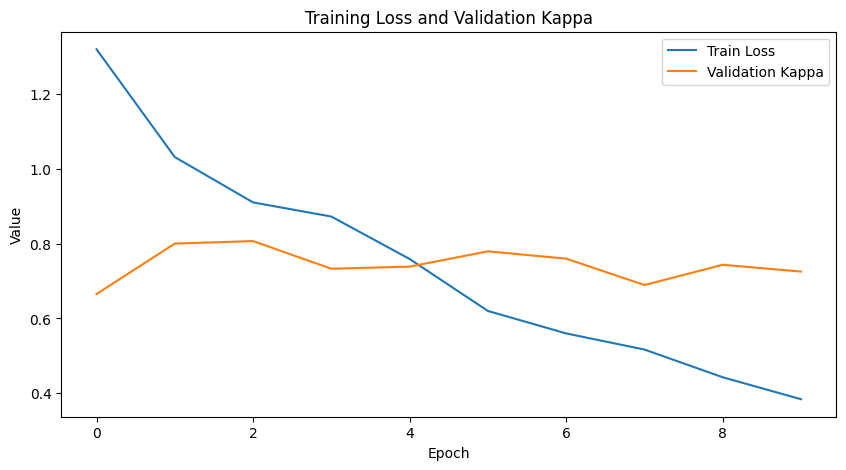

<ipython-input-8-a1e963f90f7c>:250: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'dual_{model_name}_best_model.pth'))


Predictions saved to ./dual_test_predictions.csv


In [ ]:
import copy
import os
import random
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

# Hyper Parameters
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 10

# Define Dual Model Loading Logic
def load_dual_model(model_name, num_classes=5):
    if model_name == "resnet18":
        base_model = models.resnet18(pretrained=True)
    elif model_name == "resnet34":
        base_model = models.resnet34(pretrained=True)
    elif model_name == "vgg16":
        base_model = models.vgg16(pretrained=True)
        base_model.classifier[-1] = nn.Identity()
    elif model_name == "efficientnet_b0":
        base_model = models.efficientnet_b0(pretrained=True)
        base_model.classifier[-1] = nn.Identity()
    elif model_name == "densenet121":
        base_model = models.densenet121(pretrained=True)
        base_model.classifier = nn.Identity()
    else:
        raise ValueError(f"Model {model_name} not supported.")

    if hasattr(base_model, "fc"):
        base_model.fc = nn.Identity()

    class DualInputModel(nn.Module):
        def __init__(self):
            super(DualInputModel, self).__init__()
            self.base_model1 = copy.deepcopy(base_model)
            self.base_model2 = copy.deepcopy(base_model)
            feature_dim = 512 if model_name.startswith("resnet") else 1280 if model_name.startswith("efficientnet") else 4096
            self.fc = nn.Sequential(
                nn.Linear(feature_dim * 2, 256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, num_classes)
            )

        def forward(self, x1, x2):
            f1 = self.base_model1(x1)
            f2 = self.base_model2(x2)
            features = torch.cat([f1, f2], dim=1)
            out = self.fc(features)
            return out

    return DualInputModel()
# Transformations
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Dual Dataset Definition
class DualRetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform
        self.test = test
        self.data = self.load_data()

    def load_data(self):
        df = pd.read_csv(self.ann_file)
        data = []
        for i in range(0, len(df), 2):  # Pair images
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, df.iloc[i]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, df.iloc[i + 1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(df.iloc[i]['patient_DR_Level'])
            data.append(file_info)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return (img1, img2), label,data['img_path1'],data['img_path2']
        else:
            return img1, img2,data['img_path1'],data['img_path2']

# Dual Training Function
def train_dual_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25, checkpoint_path='dual_model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0
    history = {"train_loss": [], "val_kappa": []}

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit='batch', file=sys.stdout) as pbar:
            for (img1, img2), labels, _, _ in train_loader: # Change is here: unpack the 4 returned values, ignoring the last two (image paths)
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())
                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        train_loss = sum(running_loss) / len(running_loss)
        train_kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
        print(f'Train Loss: {train_loss:.4f}, Train Kappa: {train_kappa:.4f}')

        # Validate
        val_kappa = validate_dual_model(model, val_loader, device)
        history["train_loss"].append(train_loss)
        history["val_kappa"].append(val_kappa)
        print(f'Validation Kappa: {val_kappa:.4f}')

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'Best Validation Kappa: {best_val_kappa:.4f} at Epoch {best_epoch}')

    # Plot Training History
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_kappa"], label="Validation Kappa")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Training Loss and Validation Kappa")
    plt.legend()
    plt.show()

    return model

# Dual Validation Function
def validate_dual_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for (img1, img2), labels, _, _ in val_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return cohen_kappa_score(all_labels, all_preds, weights='quadratic')

# Test Evaluation Function for Dual Model
def evaluate_dual_test_data(model, test_loader, device):
    model.eval()
    all_preds = []
    all_image_ids = []
    with torch.no_grad():
        for img1, img2, path1, path2 in test_loader: # Change: unpack all 4 values
            img1, img2 = img1.to(device), img2.to(device)
            outputs = model(img1, img2)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())

            # Collect image IDs for submission using path1
            batch_image_ids = [os.path.basename(p) for p in path1]
            all_image_ids.extend(batch_image_ids)

    # Save predictions to CSV
    submission_df = pd.DataFrame({"ID": all_image_ids, "Target": all_preds})
    submission_df.to_csv("./dual_test_predictions.csv", index=False)
    print("Predictions saved to ./dual_test_predictions.csv")

# Main Execution
if __name__ == '__main__':
    # Select Model
    model_name = "efficientnet_b0"  # Choose from resnet18, resnet34, vgg16, efficientnet_b0, densenet121

    # Load Model
    model = load_dual_model(model_name, num_classes)

    # Dataset and DataLoader
    # Dataset and DataLoader
    train_dataset = DualRetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/train.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/train/', transform_train)
    val_dataset = DualRetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/val.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/val/', transform_test)
    test_dataset = DualRetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/', transform_test, test=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Criterion and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train Model
    model = train_dual_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=num_epochs, checkpoint_path=f'dual_{model_name}_best_model.pth')

    # Load Best Model
    model.load_state_dict(torch.load(f'dual_{model_name}_best_model.pth'))

    # Evaluate on Test Data
    evaluate_dual_test_data(model, test_loader, device)


In [ ]:
# Grad-CAM Implementation
def generate_gradcam(model, image, target_layer, device):
    model.eval()
    image = image.unsqueeze(0).to(device)

    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle1 = target_layer.register_forward_hook(forward_hook)
    handle2 = target_layer.register_backward_hook(backward_hook)

    output = model(image)
    target_class = torch.argmax(output, dim=1)
    loss = output[0, target_class]
    loss.backward()

    handle1.remove()
    handle2.remove()

    gradients = gradients[0].cpu().data.numpy()[0]
    activations = activations[0].cpu().data.numpy()[0]

    weights = np.mean(gradients, axis=(1, 2))
    cam = np.zeros(activations.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * activations[i]

    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam

In [ ]:
# Grad-CAM Implementation (Modified)
def generate_gradcam(model, image1, image2, target_layer, device):
    model.eval()
    image1 = image1.unsqueeze(0).to(device)
    image2 = image2.unsqueeze(0).to(device)

    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle1 = target_layer.register_forward_hook(forward_hook)
    handle2 = target_layer.register_backward_hook(backward_hook)

    output = model(image1, image2)
    target_class = torch.argmax(output, dim=1)
    loss = output[0, target_class]
    loss.backward()

    handle1.remove()
    handle2.remove()

    gradients = gradients[0].cpu().data.numpy()[0]
    activations = activations[0].cpu().data.numpy()[0]

    weights = np.mean(gradients, axis=(1, 2))
    cam = np.zeros(activations.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * activations[i]

    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


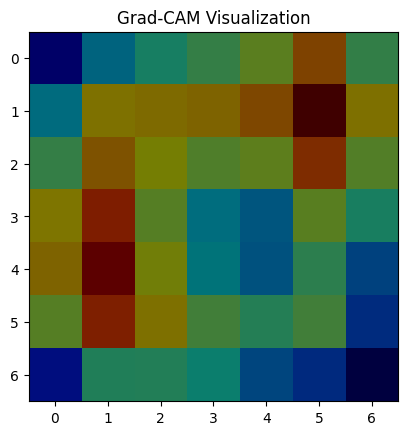

In [ ]:
# Grad-CAM Visualization Example (Modified)
if __name__ == '__main__':
    (example_image1, example_image2), _, _, _ = train_dataset[0]  # Unpack all 4 values, ignore the last three

    cam = generate_gradcam(model, example_image1, example_image2, target_layer=model.base_model1.layer4[-1], device=device) # Pass both images to generate_gradcam

    plt.imshow(example_image1.permute(1, 2, 0).numpy())
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Visualization")
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10
Training: 100%|██████████| 25/25 [05:21<00:00, 12.87s/batch, Loss=0.9642]
Train Loss: 1.3361, Train Kappa: 0.4945
Validation Kappa: 0.6595

Epoch 2/10
Training: 100%|██████████| 25/25 [05:21<00:00, 12.85s/batch, Loss=0.9470]
Train Loss: 1.0172, Train Kappa: 0.7231
Validation Kappa: 0.7039

Epoch 3/10
Training: 100%|██████████| 25/25 [05:18<00:00, 12.76s/batch, Loss=0.7976]
Train Loss: 0.9209, Train Kappa: 0.7826
Validation Kappa: 0.7099

Epoch 4/10
Training: 100%|██████████| 25/25 [05:17<00:00, 12.70s/batch, Loss=0.6971]
Train Loss: 0.8341, Train Kappa: 0.7903
Validation Kappa: 0.6759

Epoch 5/10
Training: 100%|██████████| 25/25 [05:16<00:00, 12.67s/batch, Loss=0.8469]
Train Loss: 0.7598, Train Kappa: 0.8506
Validation Kappa: 0.7477

Epoch 6/10
Training: 100%|██████████| 25/25 [05:16<00:00, 12.66s/batch, Loss=0.5120]
Train Loss: 0.6394, Train Kappa: 0.8609
Validation Kappa: 0.6597

Epoch 7/10
Training: 100%|██████████| 25/25 [05:18<00:00, 12.72s/batch, Loss=0.7319]
Train Lo

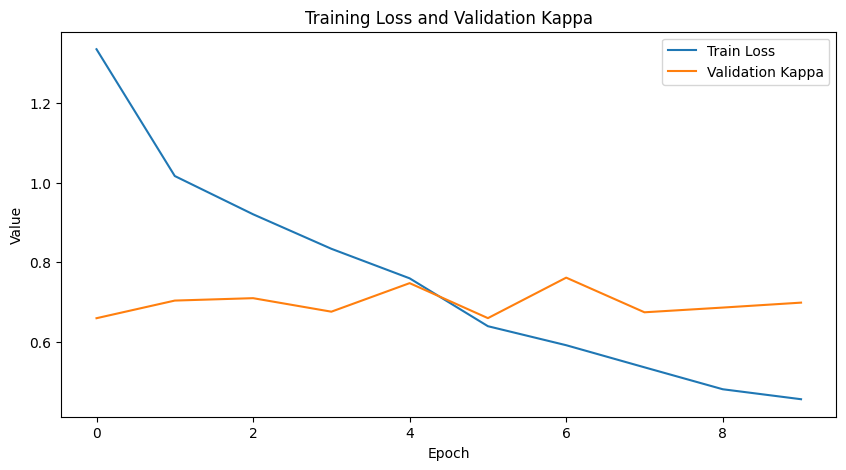

<ipython-input-15-ec19e77c9c48>:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'dual_{model_name}_best_model.pth'))


Predictions saved to ./dual_test_predictions.csv


In [ ]:
!pip install tqdm

import copy
import os
import random
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import cohen_kappa_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm

# Hyper Parameters
batch_size = 24
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 10

# Define Dual Model Loading Logic
def load_dual_model(model_name, num_classes=5):
    if model_name == "resnet18":
        base_model = models.resnet18(pretrained=True)
    elif model_name == "resnet34":
        base_model = models.resnet34(pretrained=True)
    elif model_name == "vgg16":
        base_model = models.vgg16(pretrained=True)
        base_model.classifier[-1] = nn.Identity()
    elif model_name == "efficientnet_b0":
        base_model = models.efficientnet_b0(pretrained=True)
        base_model.classifier[-1] = nn.Identity()
    elif model_name == "densenet121":
        base_model = models.densenet121(pretrained=True)
        base_model.classifier = nn.Identity()
    else:
        raise ValueError(f"Model {model_name} not supported.")

    if hasattr(base_model, "fc"):
        base_model.fc = nn.Identity()

    class DualInputModel(nn.Module):
        def __init__(self):
            super(DualInputModel, self).__init__()
            self.base_model1 = copy.deepcopy(base_model)
            self.base_model2 = copy.deepcopy(base_model)
            feature_dim = 512 if model_name.startswith("resnet") else 1280 if model_name.startswith("efficientnet") else 4096
            self.fc = nn.Sequential(
                nn.Linear(feature_dim * 2, 256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, num_classes)
            )

        def forward(self, x1, x2):
            f1 = self.base_model1(x1)
            f2 = self.base_model2(x2)
            features = torch.cat([f1, f2], dim=1)
            out = self.fc(features)
            return out

    return DualInputModel()

# Transformations
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dual Dataset Definition (Modified)
class DualRetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform
        self.test = test
        self.data = self.load_data()

    def load_data(self):
        df = pd.read_csv(self.ann_file)
        if not self.test:  # For training and validation, load pairs
            data = []
            for i in range(0, len(df), 2):
                file_info = dict()
                file_info['img_path1'] = os.path.join(self.image_dir, df.iloc[i]['img_path'])
                file_info['img_path2'] = os.path.join(self.image_dir, df.iloc[i + 1]['img_path'])
                file_info['dr_level'] = int(df.iloc[i]['patient_DR_Level'])
                data.append(file_info)
        else:  # For testing, load individual images
            data = []
            for i in range(len(df)):
                file_info = dict()
                file_info['img_path1'] = os.path.join(self.image_dir, df.iloc[i]['img_path'])
                # For testing, use the same image for both inputs
                file_info['img_path2'] = file_info['img_path1']
                data.append(file_info)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return (img1, img2), label, data['img_path1'], data['img_path2']
        else:
            return img1, img2, data['img_path1'], data['img_path2']

# Dual Training Function
def train_dual_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25, checkpoint_path='dual_model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0
    history = {"train_loss": [], "val_kappa": []}

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit='batch', file=sys.stdout) as pbar:
            for (img1, img2), labels, _, _ in train_loader: # Change is here: unpack the 4 returned values, ignoring the last two (image paths)
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())
                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        train_loss = sum(running_loss) / len(running_loss)
        train_kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
        print(f'Train Loss: {train_loss:.4f}, Train Kappa: {train_kappa:.4f}')

        # Validate
        val_kappa = validate_dual_model(model, val_loader, device)
        history["train_loss"].append(train_loss)
        history["val_kappa"].append(val_kappa)
        print(f'Validation Kappa: {val_kappa:.4f}')

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'Best Validation Kappa: {best_val_kappa:.4f} at Epoch {best_epoch}')

    # Plot Training History
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_kappa"], label="Validation Kappa")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Training Loss and Validation Kappa")
    plt.legend()
    plt.show()

    return model

# Dual Validation Function
def validate_dual_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for (img1, img2), labels, _, _ in val_loader: # Change: unpack 4 values, ignore the last two (image paths)
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return cohen_kappa_score(all_labels, all_preds, weights='quadratic')

# Test Evaluation Function for Dual Model
def evaluate_dual_test_data(model, test_loader, device):
    model.eval()
    all_preds = []
    all_image_ids = []
    with torch.no_grad():
        for img1, img2, path1, path2 in test_loader: # Change: unpack all 4 values
            img1, img2 = img1.to(device), img2.to(device)
            outputs = model(img1, img2)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())

            # Collect image IDs for submission using path1
            batch_image_ids = [os.path.basename(p) for p in path1]
            all_image_ids.extend(batch_image_ids)

    # Save predictions to CSV
    submission_df = pd.DataFrame({"ID": all_image_ids, "Target": all_preds})
    submission_df.to_csv("./dual_test_predictions.csv", index=False)
    print("Predictions saved to ./dual_test_predictions.csv")

# Main Execution
if __name__ == '__main__':
    # Select Model
    model_name = "resnet18"  # Choose from resnet18, resnet34, vgg16, efficientnet_b0, densenet121

    # Load Model
    model = load_dual_model(model_name, num_classes)

    # Dataset and DataLoader
    # Dataset and DataLoader
    train_dataset = DualRetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/train.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/train/', transform_train)
    val_dataset = DualRetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/val.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/val/', transform_test)
    test_dataset = DualRetinopathyDataset('/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/521153S-3005-final-project/DeepDRiD/test/', transform_test, test=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Criterion and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train Model
    model = train_dual_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=num_epochs, checkpoint_path=f'dual_{model_name}_best_model.pth')

    # Load Best Model
    model.load_state_dict(torch.load(f'dual_{model_name}_best_model.pth'))

    # Evaluate on Test Data
    evaluate_dual_test_data(model, test_loader, device)

